# Imports

In [1]:
# Imports
import torch
import torchvision                                       # torch package for vision related things
import torch.nn.functional as F                          # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets                  # Standard datasets
import torchvision.transforms as transforms              # Transformations we can perform on our dataset for augmentation
from torch import optim                                  # For optimizers like SGD, Adam, etc.
from torch import nn                                     # All neural network modules
from torch.utils.data import DataLoader                  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm                                    # For nice progress bar!
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Setting some hyperparameters

In [2]:
# Hyperparameters
in_channels = 3
num_classes = 10
lr = 4e-3
batch_size = 128
num_epochs = 5
dim = 128
depth = 3
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the dataset

In [3]:
# Load Data
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(in_channels)], [0.5 for _ in range(in_channels)]
                            ),
    ]
                                )

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:04<00:00, 38093408.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


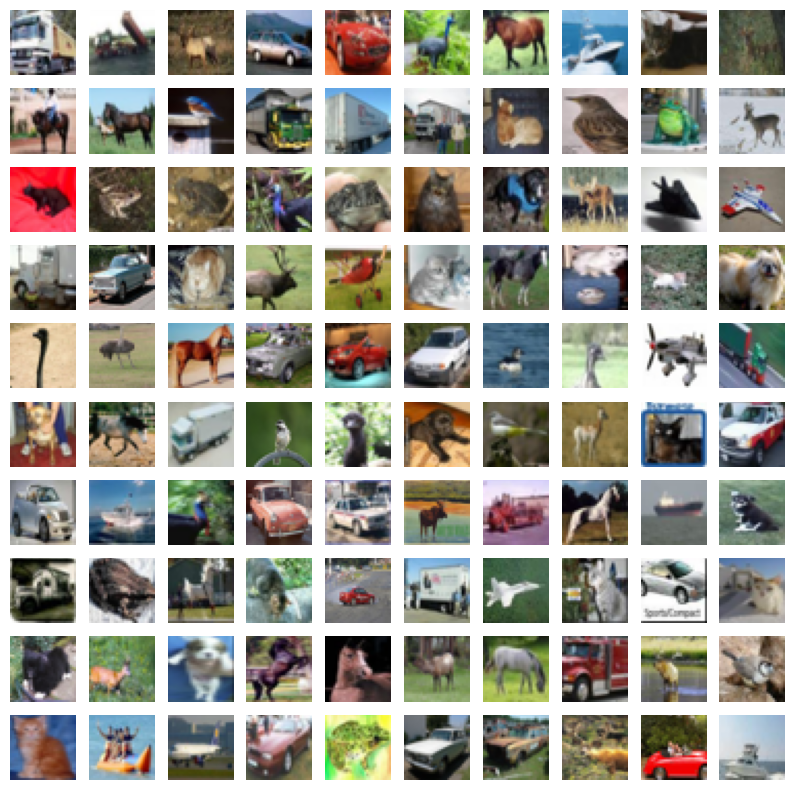

In [4]:
plt.figure(figsize=(10, 10))
for i in range(1, 101, 1):
  plt.subplot(10, 10, i)
  plt.imshow(trainset.data[i])
  plt.axis('off')
plt.show()

# Defining ConvMixer Layer and the Whole Architecture
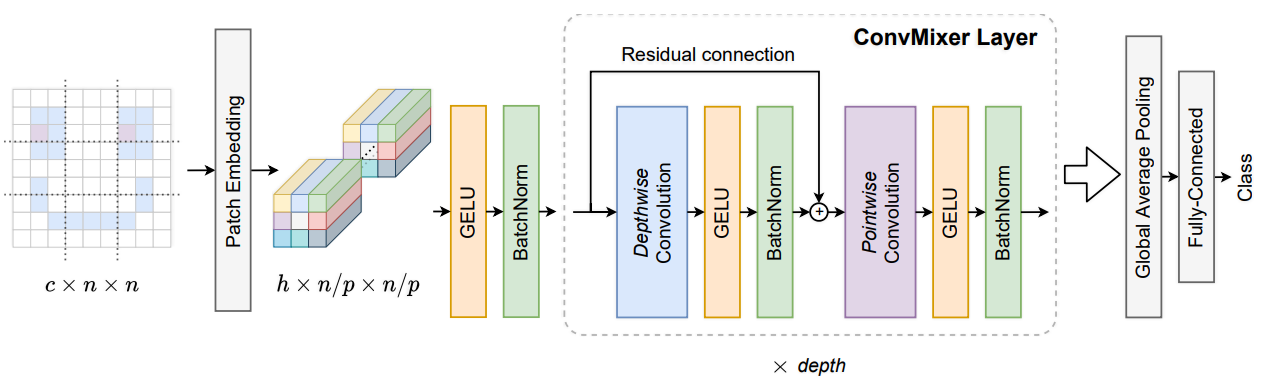


In [5]:
class ConvMixerLayer(nn.Module):
    """The ConvMixer layer which is nothing but applying
       a Depth-Wise Convolution with skip connection followed
       by applying a Point-Wise Convolution.
       output = point_wise_conv(depth_wise_conv(input) + input)"""
    def __init__(self, dim, kernel_size):
        super().__init__()

        self.depth_wise_conv = nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )

        self.point_wise_conv = nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
                )

    def forward(self, x):
        return self.point_wise_conv(self.depth_wise_conv(x) + x)

class ConvMixer(nn.Module):
    """The whole ConvMixer architecture which consists of:
       1-Patch Embedding layer
       2-Several applications of ConvMixer layer
       according to the depth of the network.
       3-Global Average Pooling and flattening
       4-Passing feature to the classifier"""
    def __init__(self, in_channels, dim, depth, kernel_size=9, patch_size=7, num_classes=10):
        super().__init__()

        self.patch_embedding = nn.Sequential(nn.Conv2d(in_channels, dim, kernel_size=patch_size, stride=patch_size),
                                             nn.GELU(),
                                             nn.BatchNorm2d(dim)
                                            )

        self.conv_mixer_layers = nn.ModuleList([ConvMixerLayer(dim, kernel_size) for _ in range(depth)])

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)              # Patch Embedding layer
        for mixer in self.conv_mixer_layers:     # Applying Mixer Layer N times
            x = mixer(x)
        x = self.avgpool(x)
        x = self.flatten(x)                      # Global Average Pooling

        return self.classifier(x)

# Instantiating model and defining loss function and optimizer

In [6]:
model = ConvMixer(in_channels, dim, depth, kernel_size=5, patch_size=4, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,)

# Training loop

In [8]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for batch_index, (images, targets) in loop:
        images = images.to(device)
        targets = targets.to(device)
        logits = model(images)
        loss =  criterion(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # progress bar information updating
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

# Defining a loop for getting the accuracy of model on train and test splits

In [7]:
# get accuracy on training & test to see how good our model is
def get_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            logits = model(x)
            _, predictions = logits.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

In [9]:
print(f"Accuracy on training set: {get_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {get_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 81.56
Accuracy on test set: 71.92
